# Prediction of article prices

Problem definition: Build an algorithm which predicts article prices based on product characteristerics.

In [600]:
import pandas as pd
from sqlalchemy import create_engine
import os
import json
import numpy as np

def load_credentials(path = "aws_rds_credentials.json"):
     with open(path, 'r') as file:
          config = json.load(file)

     # set up credentials
     for key in config.keys():
          os.environ[key] = config[key]

     return


load_credentials()

aws_rds_url = f"postgresql://{os.environ['user']}:{os.environ['password']}@{os.environ['host']}:{os.environ['port']}/{os.environ['database']}?sslmode=require"

# Load a sample dataset
def load_data():
    engine = create_engine(aws_rds_url)
    sql_query = f"""SELECT * 
                    FROM public.tracking_staging 
                    """
    df = pd.read_sql(sql_query, engine)
    return (df)

data = load_data()
data

,product_id,catalog_id,brand_title,date,size_title,color1_id,favourite_count,view_count,created_at,original_price_numeric,price_numeric,package_size_id,service_fee,city,country,color1,status,description,item_closing_action,user_id
0,3943157075,2006.0,CASA,2024-02-21,,16.0,12.0,69.0,2024-01-05,2.0,2.0,1.0,0.80,Cagnes-sur-Mer,France,Caqui,Novo com etiquetas,Neuve avec étiquette,None,21172815.0
1,3861241052,1666.0,IKKS,2024-02-21,S,9.0,1.0,5.0,2023-12-09,5.0,4.0,1.0,0.90,Cagnes-sur-Mer,France,Azul,Muito bom,We are young,None,21172815.0
2,3764399949,1763.0,Scratch,2024-02-21,10 anos / 140 cm,None,1.0,8.0,2023-11-15,15.0,15.0,1.0,1.45,Cagnes-sur-Mer,France,None,Muito bom,Cartes pour apprendre à coder,None,21172815.0
3,3730758676,1764.0,Tsum tsum,2024-02-21,4 anos / 104 cm,None,0.0,7.0,2023-11-08,2.0,2.0,1.0,0.80,Cagnes-sur-Mer,France,None,Muito bom,Anna et Elsa,None,21172815.0
4,3717642430,2339.0,,2024-02-21,,None,0.0,0.0,2023-11-05,3.0,3.0,1.0,0.85,Cagnes-sur-Mer,France,None,Muito bom,Très bon état,None,21172815.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658538,4005800233,1606.0,Revolution,2024-02-21,5 anos / 110 cm,5.0,0.0,1.0,2024-01-21,3.0,3.0,1.0,0.85,Cagnes-sur-Mer,France,Fúcsia,Muito bom,Combishort\nPorté 1 fois 1 heure,None,21172815.0
658539,4005767100,1606.0,Revolution,2024-02-21,5 anos / 110 cm,12.0,0.0,4.0,2024-01-21,10.0,8.0,1.0,1.10,Cagnes-sur-Mer,France,Branco,Muito bom,Show Angel \nPorté 1 fois 1 heure,None,21172815.0
658540,3943168819,158.0,IKKS,2024-02-21,,3.0,1.0,68.0,2024-01-05,10.0,8.0,1.0,1.10,Cagnes-sur-Mer,France,Cinzento,Satisfatório,Cuir veilli,None,21172815.0
658541,3943161668,161.0,Sunshine,2024-02-21,,5.0,0.0,2.0,2024-01-05,2.0,2.0,1.0,0.80,Cagnes-sur-Mer,France,Fúcsia,Muito bom,Très bon état,None,21172815.0


In [601]:
data.drop_duplicates(subset='product_id', inplace=True, keep= "last")
data

,product_id,catalog_id,brand_title,date,size_title,color1_id,favourite_count,view_count,created_at,original_price_numeric,price_numeric,package_size_id,service_fee,city,country,color1,status,description,item_closing_action,user_id
34,3636130842,1590.0,Nabaiji,2024-02-21,12 anos / 152 cm,5.0,5.0,28.0,2023-10-20,1.0,1.0,1.0,0.75,Cagnes-sur-Mer,France,Fúcsia,Muito bom,Très peu porté Sans étiquette,None,21172815.0
317,4058674803,2339.0,,2024-02-21,,None,1.0,1.0,2024-02-03,2.0,2.0,1.0,0.80,Congénies,France,None,Muito bom,Lu 1 fois.\n500p,None,12043348.0
396,4099258457,2676.0,Nike,2024-02-21,42,26.0,34.0,464.0,2024-02-14,160.0,130.0,1.0,7.20,San Nicola La Strada,Italia,Azul claro,Novo com etiquetas,Vendo Nike Mercurial Superfly professionali AC...,None,176350478.0
500,4057150173,2338.0,,2024-02-21,,None,0.0,0.0,2024-02-03,2.0,2.0,2.0,0.80,Congénies,France,None,Bom,Bon état,None,12043348.0
942,4128871518,218.0,Livera,2024-02-21,XL / 42 / 14,2.0,5.0,46.0,2024-02-21,3.0,3.0,1.0,0.85,Haps,Pays-Bas,Castanho,Muito bom,Van Livera\nMaat 42,None,63460095.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658538,4005800233,1606.0,Revolution,2024-02-21,5 anos / 110 cm,5.0,0.0,1.0,2024-01-21,3.0,3.0,1.0,0.85,Cagnes-sur-Mer,France,Fúcsia,Muito bom,Combishort\nPorté 1 fois 1 heure,None,21172815.0
658539,4005767100,1606.0,Revolution,2024-02-21,5 anos / 110 cm,12.0,0.0,4.0,2024-01-21,10.0,8.0,1.0,1.10,Cagnes-sur-Mer,France,Branco,Muito bom,Show Angel \nPorté 1 fois 1 heure,None,21172815.0
658540,3943168819,158.0,IKKS,2024-02-21,,3.0,1.0,68.0,2024-01-05,10.0,8.0,1.0,1.10,Cagnes-sur-Mer,France,Cinzento,Satisfatório,Cuir veilli,None,21172815.0
658541,3943161668,161.0,Sunshine,2024-02-21,,5.0,0.0,2.0,2024-01-05,2.0,2.0,1.0,0.80,Cagnes-sur-Mer,France,Fúcsia,Muito bom,Très bon état,None,21172815.0


In [602]:
data["elapsed"] = pd.to_datetime(data['date']) - pd.to_datetime(data['created_at']) 
data["elapsed"] = data["elapsed"].dt.days.astype("int64")

IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [ ]:
#data = data[["size_title", "color1", "brand_title", "price_numeric", "status", "catalog_id", "package_size_id", "country", "view_count", "favourite_count", "elapsed"]]
data = data[["size_title", "color1_id", "brand_title", "price_numeric", "status", "catalog_id", "package_size_id", "country"]]

#date_90_days_ago = pd.Timestamp('today') - pd.Timedelta(days=180)
#data['created_at'] = pd.to_datetime(data['created_at'])
#data = data[data['created_at'] < date_90_days_ago]
#data = data.drop("created_at", axis = 1)
data

,size_title,color1_id,brand_title,price_numeric,status,catalog_id,package_size_id,view_count,country,elapsed,favourite_count
8,,3.0,Local,5,Muito bom,1962,1,10,España,11,1
13,XL,7.0,Nike,20,Novo com etiquetas,584,1,116,France,11,12
17,XXL,15.0,Jordan,29,Novo com etiquetas,1807,1,33,Italië,1,5
26,PT 38 | W29,27.0,Wrangler,5,Novo com etiquetas,1819,1,101,Italië,6,5
156,XL,3.0,Red Soul,35,Muito bom,264,1,48,France,5,1
...,...,...,...,...,...,...,...,...,...,...,...
99995,XS / 34 / 6,1.0,Promod,4,Bom,228,1,7,France,24,0
99996,M / 38 / 10,1.0,Miss Selfridge,18,Novo com etiquetas,1055,1,29,France,68,4
99997,L / 40 / 12,1.0,Daysie,3,Bom,1846,1,7,France,68,0
99998,S / 36 / 8,16.0,Kiabi,5,Bom,1055,1,4,France,68,0


## Dataframe inspection

Let's use df.info(), describe() and null count to check the properties of the dataframe.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28950 entries, 8 to 99999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   size_title       28950 non-null  object
 1   color1_id        25131 non-null  object
 2   brand_title      28950 non-null  object
 3   price_numeric    28950 non-null  int64 
 4   status           28950 non-null  object
 5   catalog_id       28950 non-null  int64 
 6   package_size_id  28950 non-null  int64 
 7   view_count       28950 non-null  int64 
 8   country          28950 non-null  object
 9   elapsed          28950 non-null  int64 
 10  favourite_count  28950 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 2.7+ MB


In [ ]:
data.describe(include = 'object')

,size_title,color1_id,brand_title,status,country
count,28950,25131,28950,28950,28950
unique,238,53,5231,5,37
top,,1.0,,Muito bom,France
freq,5612,6986,4634,15856,11241


In [ ]:
data.isnull().sum()

size_title            0
color1_id          3819
brand_title           0
price_numeric         0
status                0
catalog_id            0
package_size_id       0
view_count            0
country               0
elapsed               0
favourite_count       0
dtype: int64

In [ ]:
#data["package_size_id"] = data["package_size_id"].fillna(value = -1)
#data["country"] = data["country"].fillna(value = "null")

## Issues so far:

- catalog_id is int64, other predictors are object. Need to convert them to categorical before feeding to LightGBM
- color1_id has missing values (why?)
    - after inspecting and being knowledgeable about the data, there are articles which by nature do not have colors (such as books)
- the most popular size_title is ""
    - after inspecting I realize this has to do with "sizeless" items such as books as well
- the most popular brand_title is ""
    - this means the article doesn't have a brand. this can have several reasons, not only due to the misc items but also I believe Vinted allowed the user to publish items with empty brands at some point (I haven't confirmed this)
- size_title has 230 unique values which is a lot, let's take a look into that later
    - why is that?
- brand_title has 4.7k unique values which is also a lot
    - why is that?
## Approaches

- change dtypes
- create a dummy color1_id and assign it to articles missing color1_id (filling with value 0)
- replacing "" size_title with "no_size" for better semantic representation (otherwise users are left to guess what it means)
- replacing ""brand_title with "no_brand" for the same reason

In [ ]:
# replacing color1_id with value 0
#data["color1"] = data["color1"].fillna(value = 0)
data.isnull().sum()

size_title            0
color1_id          3819
brand_title           0
price_numeric         0
status                0
catalog_id            0
package_size_id       0
view_count            0
country               0
elapsed               0
favourite_count       0
dtype: int64

In [ ]:
data["size_title"] = data["size_title"].replace("", "no_size")
data["brand_title"] = data["brand_title"].replace("", "no_brand")
data


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,size_title,color1_id,brand_title,price_numeric,status,catalog_id,package_size_id,view_count,country,elapsed,favourite_count
8,no_size,3.0,Local,5,Muito bom,1962,1,10,España,11,1
13,XL,7.0,Nike,20,Novo com etiquetas,584,1,116,France,11,12
17,XXL,15.0,Jordan,29,Novo com etiquetas,1807,1,33,Italië,1,5
26,PT 38 | W29,27.0,Wrangler,5,Novo com etiquetas,1819,1,101,Italië,6,5
156,XL,3.0,Red Soul,35,Muito bom,264,1,48,France,5,1
...,...,...,...,...,...,...,...,...,...,...,...
99995,XS / 34 / 6,1.0,Promod,4,Bom,228,1,7,France,24,0
99996,M / 38 / 10,1.0,Miss Selfridge,18,Novo com etiquetas,1055,1,29,France,68,4
99997,L / 40 / 12,1.0,Daysie,3,Bom,1846,1,7,France,68,0
99998,S / 36 / 8,16.0,Kiabi,5,Bom,1055,1,4,France,68,0


## Taking a deeper look into size title

Size title has unbalanced labels.
- Sizes can be further divided into product types. For instance, we have:
    - M, XL, S, etc which are the standard clothing sizes
    - no_size for the products which do not have size labels
    - numeric sizes (40, 41) which refers to footwear
    - kids sizes (8 anos, 12 anos, etc)
    - cup sizes (95D, 80B)
    - jewelry (which im assuming 30 mm diameter refers to)
    - volume units (40 x 45 cm)
    - weight units (9-18kgs)
    - jeans sizes (waist measurements W33)

In [ ]:
import plotly.express as px

# Assuming your DataFrame is called data
fig = px.bar(data['size_title'].value_counts(), 
             x=data['size_title'].value_counts().index, 
             y=data['size_title'].value_counts().values,
             labels={'x': 'Size Title', 'y': 'Count'},
             title='Count of Size Title')
fig

## Taking a deeper look into brand title

Brand titles has too many brands.
- A lot of the brands aren't even brands (such as dri-fit, b(?), GYM, MI(?), etc)
- There are brands that mean the same thing (such as local, locale or any other meaning of thrift clothing)

In [ ]:
fig = px.bar(data['brand_title'].value_counts(), 
             x=data['brand_title'].value_counts().index, 
             y=data['brand_title'].value_counts().values,
             labels={'x': 'Brand Title', 'y': 'Count'},
             title='Count of Brand Title')
fig

## Approaches to size titles

- Feature engineering
    - We can easily split garments from shoes, if we consider shoes have only numeric values assigned to sizes
- Remove size classes below a certain threshold

In [ ]:
label_counts = data['size_title'].value_counts()

# Filter the labels with more than 100 occurrences
labels_more_than_100 = label_counts[label_counts > 100].index.tolist()

# Filter the DataFrame based on the selected labels
data = data[data['size_title'].isin(labels_more_than_100)]
data['size_title'].unique()

array(['no_size', 'XL', 'XXL', '39', 'L / 40 / 12', 'M / 38 / 10', 'XS',
       'S', 'M', 'XS / 34 / 6', '37', 'S / 36 / 8', '8 anos / 128 cm',
       '40', '6-9 meses / 68 cm', 'XL / 42 / 14', '43', '38', 'L', '42',
       'XXXL / 46 / 18', '3-6 meses / 62\xa0cm', 'Tamanho único', '36',
       '3 anos / 98 cm', 'XXL / 44 / 16', 'XXS / 32 / 4',
       '10 anos / 140 cm', '14 anos / 164 cm', '4 anos / 104 cm',
       '6 anos / 116 cm', '18-24 meses / 86\xa0cm', '12 anos / 152 cm',
       '9-12 meses / 74\xa0cm', '12-18 meses / 80\xa0cm',
       '5 anos / 110 cm', '1-3 meses / 56\xa0cm', '44', '41'],
      dtype=object)

In [ ]:
fig = px.bar(data['brand_title'].value_counts(), 
             x=data['brand_title'].value_counts().index, 
             y=data['brand_title'].value_counts().values,
             labels={'x': 'Brand Title', 'y': 'Count'},
             title='Count of Brand Title')
fig

## Approaches to brand titles

- Remove size classes below a certain threshold

In [ ]:
label_counts = data['brand_title'].value_counts()

# Filter the labels with more than 100 occurrences
labels_more_than_100 = label_counts[label_counts > 100].index.tolist()

# Filter the DataFrame based on the selected labels
data = data[data['brand_title'].isin(labels_more_than_100)]
data['brand_title'].unique()

array(['Local', 'Nike', 'adidas', 'Camaïeu', 'Cache Cache', 'Bershka',
       'Kiabi', 'no_brand', 'Zara', 'H&M', 'Primark', 'Shein',
       'Stradivarius', 'Disney', 'Vintage Dressing', 'ONLY',
       'Tommy Hilfiger', 'Puma', 'Mango', 'Lacoste', 'Ralph Lauren',
       'Pull & Bear', 'Pimkie', 'Gémo', "Levi's", 'Vintage', 'Jennyfer'],
      dtype=object)

In [ ]:
label_counts = data['catalog_id'].value_counts()

# Filter the labels with more than 100 occurrences
labels_more_than_100 = label_counts[label_counts > 100].index.tolist()

# Filter the DataFrame based on the selected labels
data = data[data['catalog_id'].isin(labels_more_than_100)]
data["catalog_id"].unique()
#pd.DataFrame({'catalog_id': labels}).to_csv("../prediction_service/catalog_id.csv")
#print(labels)

array([ 222, 1065, 1807, 1844, 2364, 1242, 1041,  534, 2338, 2339, 2333,
       2342,  224, 2363,  196,  221, 1043, 1809,  198, 2360, 1806],
      dtype=int64)

In [605]:
pd.DataFrame(data["package_size_id"].unique()).to_csv("../prediction_service/package_size_id.csv")
pd.DataFrame(data["country"].unique()).to_csv("../prediction_service/country.csv")
pd.DataFrame(data["color1_id"].unique()).to_csv("../prediction_service/color1_id.csv")
pd.DataFrame(data["status"].unique()).to_csv("../prediction_service/status.csv")
pd.DataFrame(data["catalog_id"].unique()).to_csv("../prediction_service/catalog_id.csv")
pd.DataFrame(data["brand_title"].unique()).to_csv("../prediction_service/brand_title.csv")
pd.DataFrame(data['size_title'].unique()).to_csv("../prediction_service/size_title.csv")

In [ ]:
from sklearn.model_selection import train_test_split
# LightGBM also can handle categorical data directly We go to probe its inner method

# Transform categorical features into the appropriate type that is expected by LightGBM
for c in data.columns:
    col_type = data[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        data[c] = data[c].astype('category')
data["catalog_id"] = data["catalog_id"].astype("category")
data["package_size_id"] = data["package_size_id"].astype("category")
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3242 entries, 918 to 99985
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   size_title       3242 non-null   category
 1   color1_id        2223 non-null   category
 2   brand_title      3242 non-null   category
 3   price_numeric    3242 non-null   int64   
 4   status           3242 non-null   category
 5   catalog_id       3242 non-null   category
 6   package_size_id  3242 non-null   int64   
 7   view_count       3242 non-null   int64   
 8   country          3242 non-null   category
 9   elapsed          3242 non-null   int64   
 10  favourite_count  3242 non-null   int64   
dtypes: category(6), int64(5)
memory usage: 176.5 KB


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=["price_numeric"]), 
                                                    data["price_numeric"], 
                                                    test_size=0.2, 
                                                    random_state=42)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2593 entries, 97555 to 99730
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   size_title       2593 non-null   category
 1   color1_id        1773 non-null   category
 2   brand_title      2593 non-null   category
 3   status           2593 non-null   category
 4   catalog_id       2593 non-null   category
 5   package_size_id  2593 non-null   int64   
 6   view_count       2593 non-null   int64   
 7   country          2593 non-null   category
 8   elapsed          2593 non-null   int64   
 9   favourite_count  2593 non-null   int64   
dtypes: category(6), int64(4)
memory usage: 122.0 KB


In [ ]:
X_train

,size_title,color1_id,brand_title,status,catalog_id,package_size_id,view_count,country,elapsed,favourite_count
97555,S / 36 / 8,1.0,H&M,Muito bom,1043,1,0,France,6,0
71485,S / 36 / 8,12.0,Kiabi,Bom,221,1,1,França,76,0
76001,no_size,NaN,no_brand,Bom,2364,1,6,France,37,2
91599,XL / 42 / 14,6.0,no_brand,Muito bom,1065,1,0,France,3,0
94848,L / 40 / 12,1.0,no_brand,Novo sem etiquetas,1065,1,5,France,5,0
...,...,...,...,...,...,...,...,...,...,...
75371,S,24.0,Nike,Muito bom,1807,1,9,Italia,111,1
75643,M / 38 / 10,4.0,Zara,Muito bom,222,1,5,France,68,0
77990,44,12.0,Nike,Novo com etiquetas,1242,2,128,France,85,9
71726,M / 38 / 10,7.0,Stradivarius,Muito bom,222,1,25,Espanha,32,23


In [614]:
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import joblib

d_train=lgb.Dataset(X_train, 
                    label=y_train,
                    params={"max_bin":128})

# Define parameters for LightGBM
params = {
    'objective': 'regression',
    'metric': 'rmse',  # Root Mean Squared Error    
    'n_estimators': 600,
    'max_depth': 18,
    'num_leaves': 2**6,
    'learning_rate': 0.01
}

clf=lgb.train(params,
              d_train) 

# Prediction on the valid set
y_pred=clf.predict(X_test)

# postprocess function
y_pred = y_pred.astype(np.int16)
errors = y_pred - y_test

# save model
joblib.dump(clf, '../prediction_service/lgb.pkl')

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Found `n_estimators` in params. Will use it instead of argument


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 435
[LightGBM] [Info] Number of data points in the train set: 2593, number of used features: 10
[LightGBM] [Info] Start training from score 9.563440
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Mean Squared Error: 490.54391371340523


In [ ]:
results = pd.DataFrame([y_pred, y_test]).T
results.columns = ["Prediction", "Test"]
results

,Prediction,Test
0,68,50
1,2,3
2,5,3
3,3,2
4,8,2
...,...,...
644,8,12
645,4,2
646,63,110
647,7,8


Text(0.5, 1.0, 'Actual vs. Predicted')

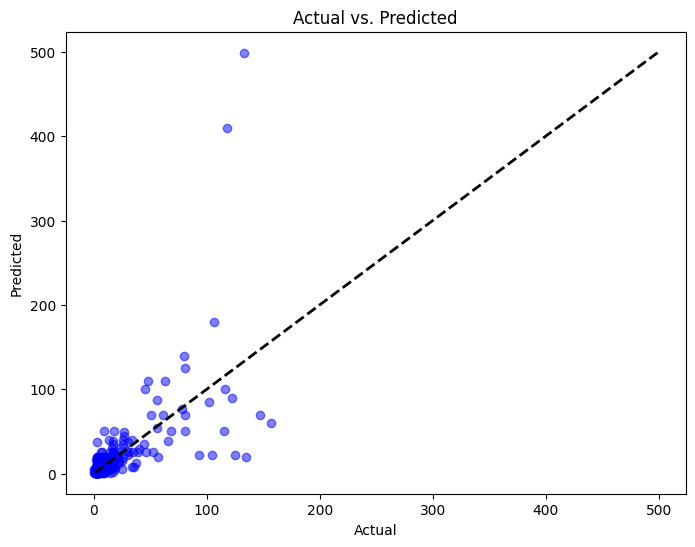

In [ ]:
import matplotlib.pyplot as plt

# y_pred/y_test QQ plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, y_test, color='blue', alpha=0.5)
plt.plot([y_test.min(), 
          y_test.max()], 
          [y_test.min(), 
           y_test.max()], 
           'k--', 
           lw=2)  # Diagonal line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted')

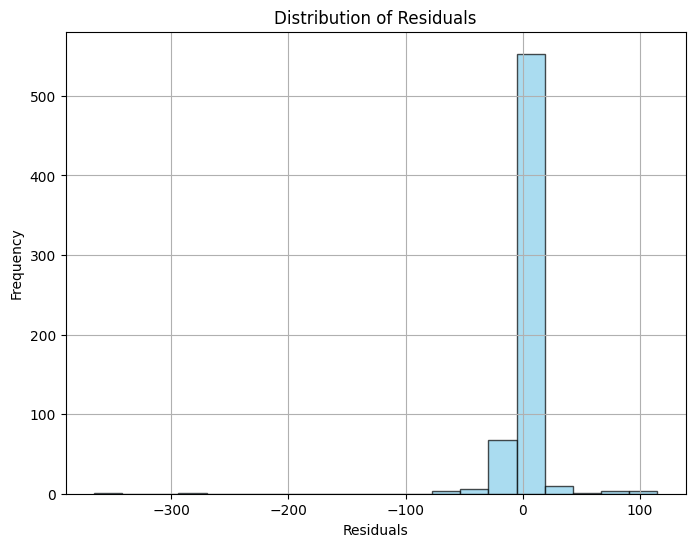

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(errors, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)

In [ ]:
import shap

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)
pd.DataFrame(shap_values, columns= X_test.columns).apply(np.abs).mean(axis = 0)

size_title         1.220706
color1_id          0.233791
brand_title        2.690400
status             0.930593
catalog_id         3.574541
package_size_id    1.974361
view_count         1.628303
country            0.623301
elapsed            0.798395
favourite_count    0.324177
dtype: float64

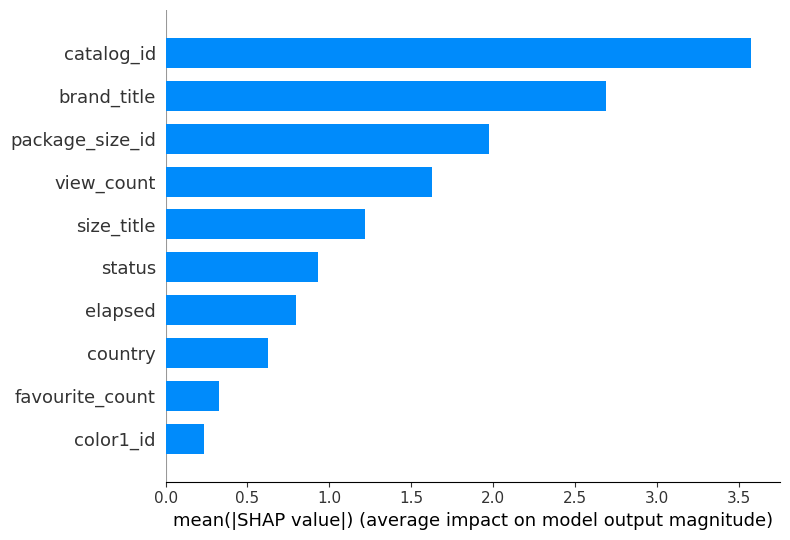

In [ ]:
shap.summary_plot(shap_values, 
                  X_test, 
                  feature_names=X_test.columns,
                  plot_type = "bar")

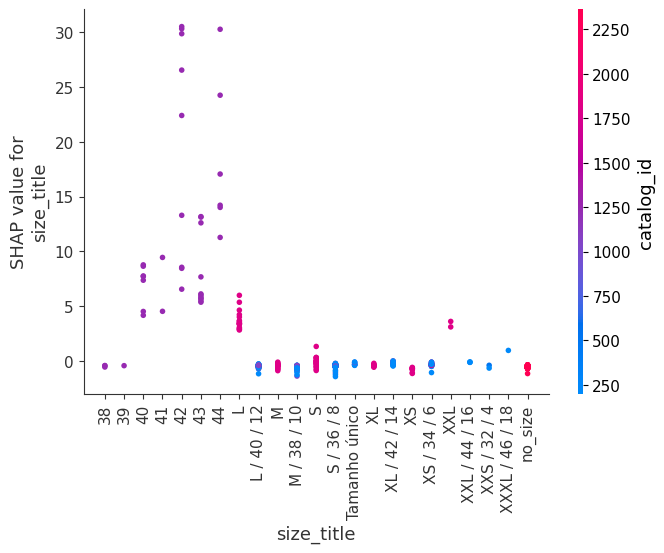

In [ ]:
shap.dependence_plot("size_title", shap_values, X_test, interaction_index="catalog_id")